# USGS Chapter 3 Describing Uncertainty

One-dimensional Tolerance Intervals

In [56]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [57]:
import pymc as pm
# import bambi as bmb
import arviz as az

## Confidence Intervals

### Normal Distribution Generated Confidence Intervals

In [58]:
def calc_data_cls(x):
    xbar = np.mean(x)
    xvar = np.var(x)
    stdev = np.sqrt(xvar)
    lcl = xbar + st.t.ppf(0.05, len(x)-1) * np.sqrt(xvar / n)
    ucl = xbar + st.t.ppf(0.95, len(x)-1) * np.sqrt(xvar / n)
    return xbar, stdev, lcl, ucl


In [59]:
def calc_data_lognorm_cls(x):
    x = np.log(x)
    xbar = np.mean(x)
    xvar = np.var(x)
    stdev = np.sqrt(xvar)
    lcl = xbar + st.t.ppf(0.05, len(x)-1) * np.sqrt(xvar / n)
    ucl = xbar + st.t.ppf(0.95, len(x)-1) * np.sqrt(xvar / n)
    return xbar, stdev, lcl, ucl


In [60]:
def generate_data(mu=5, sigma=1, random_function=np.random.normal, 
                 cl_function = calc_data_cls,
                  n=12, iterations=10):
    outMatrix = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
    xs = {}
    df = n - 1
    for i in range(iterations):
        x = random_function(mu, sigma , size=12)
        xs[i] = x
        outMatrix.loc[i,:] = cl_function(x)

    return outMatrix, xs

In [61]:
# generate data with defaults
n=12
norm_results, norm_xs = generate_data(n=n)
norm_results.round(2)


,xbar,sd,lcl,ucl
0,5.255071,0.705646,4.889245,5.620897
1,5.182737,0.96363,4.683164,5.682309
2,5.001946,1.06734,4.448608,5.555284
3,4.810526,0.551199,4.524769,5.096283
4,4.981266,0.688037,4.624569,5.337963
5,5.608944,0.651277,5.271305,5.946584
6,4.972031,0.968509,4.46993,5.474132
7,4.988468,0.769976,4.589291,5.387645
8,5.333914,0.745007,4.947682,5.720146
9,4.467763,0.714981,4.097097,4.838429


In [62]:
def plot_replicates(df_results, vline=5, n=12, 
                    title = f"90% Confidence Intervals on the Mean for Randomly Generated\nNormally Distributed Data, n=12", 
                    xlim=(3,7), ylim=None, annotate=None):
    fig, ax = plt.subplots()
    for row in df_results.index:
        ax.scatter(df_results.at[row,'xbar'], row, c='black')
        ax.hlines(row, df_results.at[row,'lcl'], df_results.at[row,'ucl'],color='black')
        if annotate:
            ax.text(df_results.at[row,'ucl']+0.1, row, annotate[row])
    ax.axvline(vline, color='black', linestyle ='dashed')
    ax.set_title(title, size=16)
    ax.set_xlabel('Chloride (mg/L)')
    ax.set_ylabel('Replicate')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

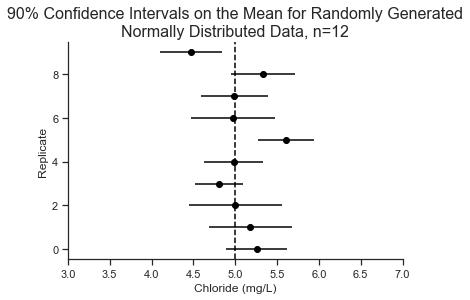

In [63]:
plot_replicates(norm_results)

### Log-normal Distribution - Generated Confidence Intervals

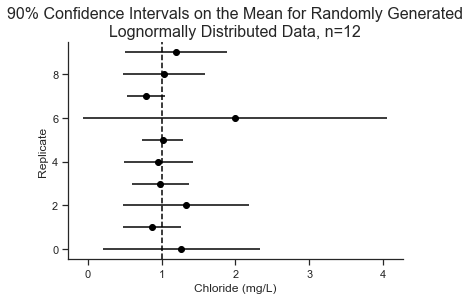

In [64]:
lnorm_results, lnorm_xs = generate_data(mu=-.5, sigma=1, random_function=np.random.lognormal)
plot_replicates(lnorm_results, vline=1, xlim=None, n=n,
                title = f"90% Confidence Intervals on the Mean for Randomly Generated\nLognormally Distributed Data, n={n}")


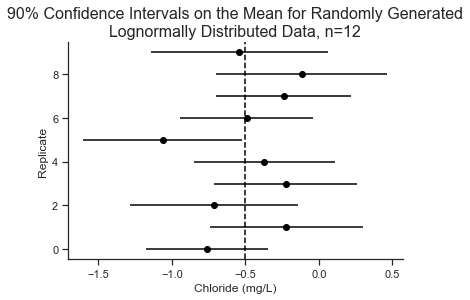

In [65]:
lnorm_results, lnorm_xs = generate_data(mu=-.5, sigma=1, random_function=np.random.lognormal,
                            cl_function=calc_data_lognorm_cls)
plot_replicates(lnorm_results, vline=-0.5, xlim=None, n=n, 
                title = f"90% Confidence Intervals on the Mean for Randomly Generated\nLognormally Distributed Data, n={n}")


In [66]:
lnorm_results = lnorm_results.astype('float')
lnorm_results


,xbar,sd,lcl,ucl
0,-0.761671,0.797453,-1.175093,-0.348250
1,-0.222606,1.003878,-0.743044,0.297832
2,-0.713473,1.097807,-1.282606,-0.144340
3,-0.226716,0.933362,-0.710596,0.257164
4,-0.371625,0.925157,-0.851251,0.108002
5,-1.062618,1.045678,-1.604726,-0.520510
6,-0.491461,0.871730,-0.943390,-0.039533
7,-0.239775,0.884421,-0.698283,0.218733
8,-0.116878,1.123122,-0.699135,0.465379
9,-0.540708,1.161289,-1.142752,0.061336


In [69]:
lnorm_results = lnorm_results.astype('float')
lnorm_results = np.exp(lnorm_results)


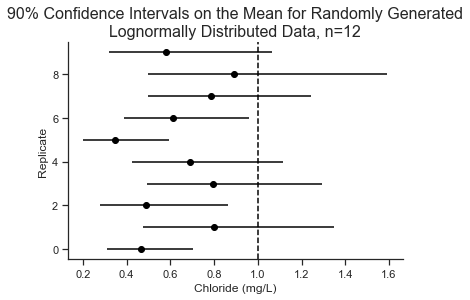

In [71]:
plot_replicates(lnorm_results,
                vline=1, xlim=None, n=n, 
                title = f"90% Confidence Intervals on the Mean for Randomly Generated\nLognormally Distributed Data, n={n}")


The point here is that the lognormal distribution leads to much more uncertainty.  

# Bayesian Way

Let's just use one replicate dataset

In [180]:
with pm.Model() as m1_univariate_normal:
    concentration = pm.Data('concentration', norm_xs[0], mutable=True)
    sigma  = pm.HalfFlat('sigma')
    mu = pm.Flat('mu')
    pm.Normal('predicted concentration', mu, sigma, observed=concentration)
    m1_idata = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gbrunkhorst\.conda\envs\pymc4\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


In [181]:
with m1_univariate_normal:
    m1_idata.extend(pm.sample_posterior_predictive(m1_idata))

In [182]:
m1_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [264]:
def normal_plot(post_df_sam, x_axis, ax):
    for row in post_df_sam.index:
        mu, sigma = post_df_sam.at[row, 'mu'], post_df_sam.at[row, 'sigma']
        if row==0:
            ax.plot(x_axis,
                st.norm.pdf(x_axis, mu, sigma),
                 color='black', alpha=.08, label='Posterior Sample (Bayes)')
        else:
            ax.plot(x_axis,
                st.norm.pdf(x_axis, mu, sigma),
                 color='black', alpha=.08)
    

In [265]:
def plot_data_trace_dists( idata, plot_n=200, bins=10, xlim=(0,12),
                    post_dist_plot_func = normal_plot,
                    title='Data Histogram, Analytical and Bayesian Distribution Fits' ):
    fig, ax = plt.subplots()

    x_axis = np.arange(xlim[0], xlim[1], 0.001)

    # observed data
    obs = idata.constant_data['concentration'].values
    sns.histplot(obs, bins=bins, stat='density', ax=ax, label='Data')

    # posterior distribution samples
    post_df_sam  = idata.posterior.to_dataframe().sample(plot_n).reset_index(drop=True)
    post_dist_plot_func(post_df_sam, x_axis, ax)

    # posterior predictive
    pred = idata.posterior_predictive['predicted concentration'].values.flatten()
    sns.kdeplot(pred, ax=ax, lw=5,
                color='orange', label='Posterior Predictive KDE (Bayes)')
    
    # t dist on observed data
    ax.plot(x_axis, 
                st.t.pdf(x_axis, df = 12-1, loc=obs.mean(), scale=obs.std()), 
                color='lime', 
                label=f'T Distribution for Data (Analytical)')
    ax.set_xlim(xlim)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title, size=16, loc='left')
    return ax


<AxesSubplot:title={'left':'Data Histogram, Analytical and Bayesian Distribution Fits'}, ylabel='Density'>

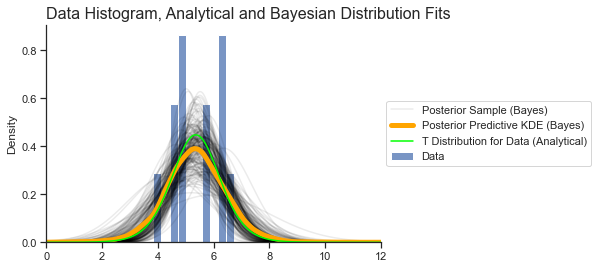

In [243]:
plot_data_trace_dists(m1_idata)

Text(0, 0.5, '')

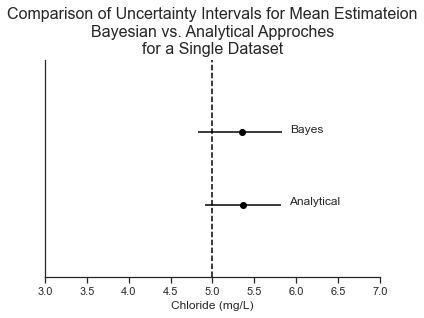

In [185]:
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = norm_results.loc[0]
mus = m1_idata.posterior['mu'].values
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], 
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

# Compare to Lognormal Data

In [186]:
with m1_univariate_normal:
    pm.set_data({'concentration': lnorm_xs[0]})
    m1_lnorm_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gbrunkhorst\.conda\envs\pymc4\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


In [187]:
with m1_univariate_normal:
    m1_lnorm_idata.extend(pm.sample_posterior_predictive(m1_lnorm_idata))

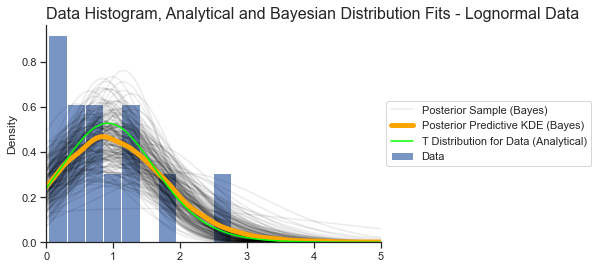

In [188]:
plot_data_trace_dists(m1_lnorm_idata, xlim=(0,5),
                    title='Data Histogram, Analytical and Bayesian Distribution Fits - Lognormal Data' )

Text(0, 0.5, '')

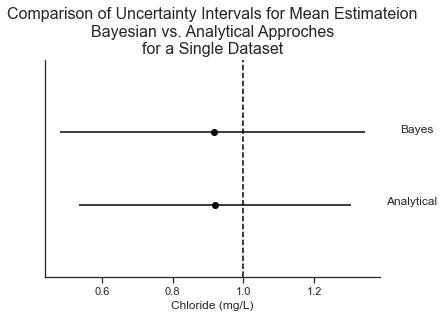

In [189]:
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = lnorm_results.loc[0]
mus = m1_lnorm_idata.posterior['mu'].values
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], xlim=None, vline=1,
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

# Lognormal Likelihood

In [190]:
with pm.Model() as m2_univariate_lnormal:
    concentration = pm.Data('concentration', lnorm_xs[0])
    sigma  = pm.HalfFlat('sigma')
    mu = pm.Flat('mu')
    pm.Lognormal('predicted concentration', mu, sigma, observed=concentration)

C:\Users\gbrunkhorst\.conda\envs\pymc4\lib\site-packages\pymc\data.py:647: FutureWarning: The `mutable` kwarg was not specified. Currently it defaults to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default will change to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Set `pm.Data(..., mutable=False/True)`, or use `pm.ConstantData`/`pm.MutableData`.
  warnings.warn(


In [191]:
with m2_univariate_lnormal:
    m2_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gbrunkhorst\.conda\envs\pymc4\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


In [192]:
with m2_univariate_lnormal:
    m2_idata.extend(pm.sample_posterior_predictive(m2_idata))

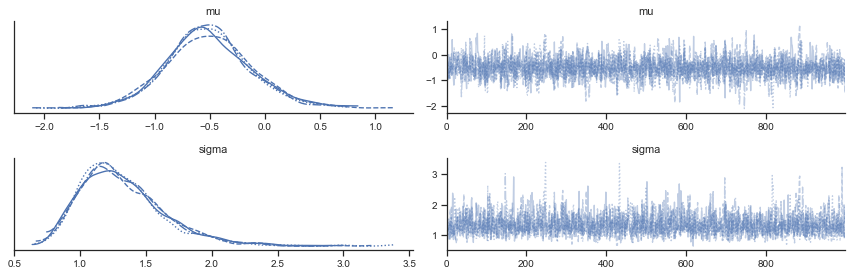

In [193]:
az.plot_trace(m2_idata)
plt.tight_layout();

In [194]:
az.summary(m2_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.510,0.395,-1.311,0.204,0.008,0.006,2494.0,2007.0,1.0
sigma,1.322,0.326,0.831,1.958,0.008,0.005,1970.0,1999.0,1.0


In [263]:
def lognormal_plot(post_df_sam,x_axis, ax):
    for row in post_df_sam.index:
        mu, sigma = post_df_sam.at[row, 'mu'], post_df_sam.at[row, 'sigma']
        if row==0:
            ax.plot(x_axis,
                st.lognorm.pdf(x_axis, loc=np.exp(mu), s=sigma),
                 color='black', alpha=.08, label='Posterior Sample Lognormal (Bayes)')
        else:
            ax.plot(x_axis,
                st.lognorm.pdf(x_axis, loc=np.exp(mu), s=sigma),
                 color='black', alpha=.08)

(0.0, 1.0)

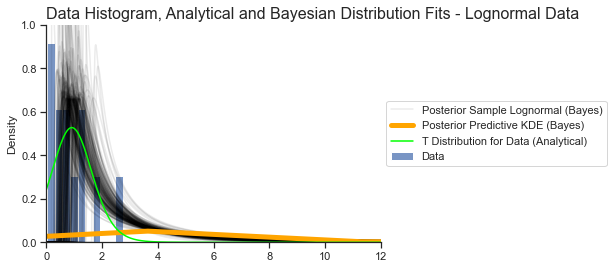

In [251]:
ax = plot_data_trace_dists(m2_idata, plot_n=200,
    post_dist_plot_func = lognormal_plot,
    title='Data Histogram, Analytical and Bayesian Distribution Fits - Lognormal Data' )
plt.ylim(0,1)


The lognormal distribution does a very poor job in the upper tail of the distribution, even though the original distribution was drawn from a lognormal dataset.  Here is the posterior predicted compared to the data.  

In [252]:
def posterior_predictive_compared_to_data(idata, percentiles=[.5,.9, .95,.99] ):
    df = pd.concat([
        pd.Series(idata.posterior_predictive['predicted concentration'].values.flatten()).describe(percentiles=percentiles),
        pd.Series(idata.constant_data['concentration'].values.flatten()).describe(percentiles= percentiles )], 
        axis=1)
    df.columns = ['Posterior Predicted','Data'] 
    return df

In [253]:
posterior_predictive_compared_to_data(m2_idata).round(2)


,Posterior Predicted,Data
count,48000.00,12.00
mean,1.81,0.92
std,11.51,0.77
min,0.00,0.04
50%,0.58,0.77
90%,3.26,1.66
95%,5.74,2.18
99%,19.50,2.64
max,1513.21,2.76


Compare the analytical normal assumed value with the lognormal Bayesian assumption. 

Text(0, 0.5, '')

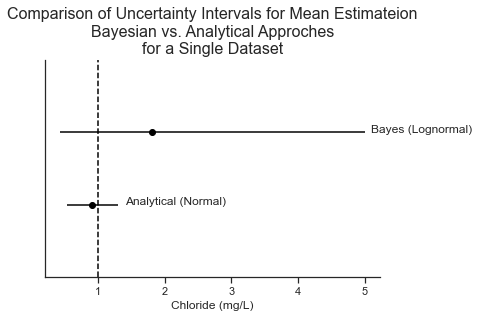

In [254]:
# based on posterior predictive
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = lnorm_results.loc[0]
mus = m2_idata.posterior_predictive['predicted concentration'].mean(axis=2).values.flatten()
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical (Normal)', 'Bayes (Lognormal)'], xlim=None, vline=1,
             title='Comparison of Uncertainty Intervals for Mean Estimateion\nBayesian vs. Analytical Approches\nfor a Single Dataset')
plt.yticks([])
plt.ylabel('')

Oddly, using the standard methods for comparing models, the lognormal model wins.  

In [255]:
compare = az.compare({'norm':m1_idata, 'lnorm':m2_idata})
compare

C:\Users\gbrunkhorst\.conda\envs\pymc4\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
lnorm,0,-15.104269,2.660982,0.000000,0.757265,3.067078,0.000000,True,log
norm,1,-17.281048,1.266944,2.176779,0.242735,1.419481,3.112251,False,log


Text(0.5, 1.0, 'LOO')

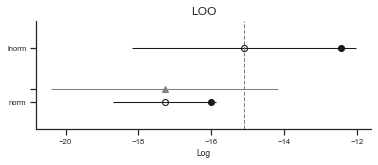

In [256]:
az.plot_compare(compare)
plt.title('LOO')

[Plot needs fully annotated legend]

# Compare to Model with Lognormalized Data

In [257]:
with m1_univariate_normal:
    pm.set_data({'concentration': np.log(lnorm_xs[0])})
    m1_logged_lnorm_idata = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gbrunkhorst\.conda\envs\pymc4\lib\site-packages\pymc\aesaraf.py:996: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 112 seconds.


In [258]:
with m1_univariate_normal:
    m1_logged_lnorm_idata.extend(pm.sample_posterior_predictive(m1_logged_lnorm_idata))

<AxesSubplot:title={'left':'Data Histogram, Analytical and Bayesian Distribution Fits - Lognormal Scaled Data'}, ylabel='Density'>

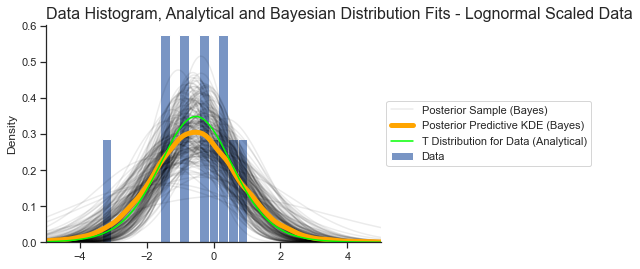

In [266]:
plot_data_trace_dists(m1_logged_lnorm_idata, xlim=(-5,5), bins=15,
    title='Data Histogram, Analytical and Bayesian Distribution Fits - Lognormal Scaled Data' )

In [267]:
posterior_predictive_compared_to_data(m1_logged_lnorm_idata).round(2)


,Posterior Predicted,Data
count,48000.00,12.00
mean,-0.55,-0.53
std,1.41,1.17
min,-11.56,-3.34
50%,-0.56,-0.26
90%,1.19,0.50
95%,1.72,0.75
99%,2.88,0.96
max,6.91,1.01


The mean fits fine, but the tails are very fat, especially when considering that we are plotting orders of magnitude.  Plot only the data and the posterior predictive.  

In [270]:
def plot_data_post_logged( idata, bins=10, xlim=(0,12),
                    title='Data Histogram and Posterior Predictive' ):
    fig, ax = plt.subplots()

    x_axis = np.arange(xlim[0], xlim[1], 0.001)

    # observed data
    obs = idata.constant_data['concentration'].values
    obs = np.exp(obs)
    sns.histplot(obs, bins=bins, stat='density', ax=ax, label='Data')

    # posterior predictive
    pred = idata.posterior_predictive['predicted concentration'].values.flatten()
    pred = np.exp(pred)
    sns.kdeplot(pred, ax=ax, lw=5,
                color='orange', label='Posterior Predictive KDE (Bayes)')
    
    ax.set_xlim(xlim)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(title, size=16, loc='left')
    return ax


<AxesSubplot:title={'left':'Data Histogram and Posterior Predictive'}, ylabel='Density'>

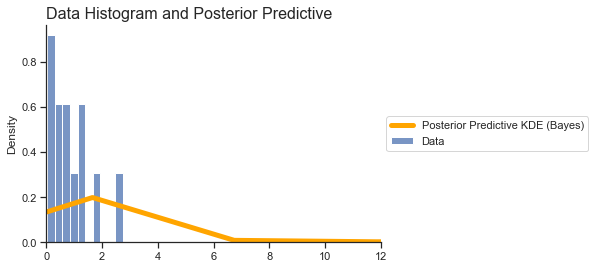

In [271]:
plot_data_post_logged(m1_logged_lnorm_idata)

Text(0.5, 0, 'Log Chloride (log mg/L)')

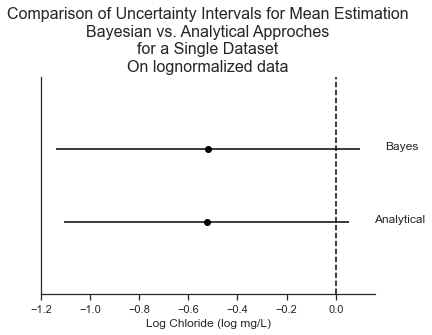

In [273]:
compare_df = pd.DataFrame(columns = ["xbar", " sd ", "lcl", "ucl" ])
compare_df.loc[0,:] = calc_data_cls(m1_logged_lnorm_idata.constant_data['concentration'].values)
mus = m1_logged_lnorm_idata.posterior['mu'].values
compare_df.loc[1,:] = [np.mean(mus),  np.std(mus),  np.quantile(mus, .05), np.quantile(mus, .95) ]
plot_replicates(compare_df, ylim=(-1,2), annotate=['Analytical', 'Bayes'], xlim=None, vline=0,
             title='Comparison of Uncertainty Intervals for Mean Estimation\nBayesian vs. Analytical Approches\nfor a Single Dataset\nOn lognormalized data')
plt.yticks([])
plt.ylabel('')
plt.xlabel('Log Chloride (log mg/L)')

# Large N

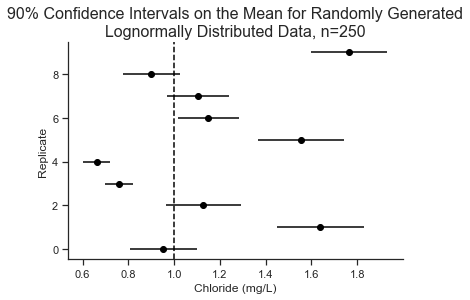

In [276]:
n=250
lnorm_results, lnorm_xs = generate_data(mu=-.5, sigma=1, random_function=np.random.lognormal, n=n)
plot_replicates(lnorm_results, vline=1, xlim=None, n=n,
    title = f"90% Confidence Intervals on the Mean for Randomly Generated\nLognormally Distributed Data, n={n}")


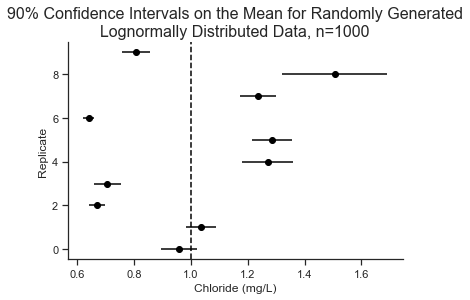

In [281]:
n=1000
lnorm_results, lnorm_xs = generate_data(mu=-.5, sigma=1, 
                random_function=np.random.lognormal, n=n)
plot_replicates(lnorm_results, vline=1, xlim=None, n=n,
    title = f"90% Confidence Intervals on the Mean for Randomly Generated\nLognormally Distributed Data, n={n}")


Interesting how this plays out.  

In [282]:
lnorm_results

,xbar,sd,lcl,ucl
0,0.957303,1.103959,0.894609,1.019998
1,1.034703,0.942125,0.981199,1.088207
2,0.670109,0.508088,0.641254,0.698964
3,0.706101,0.859147,0.65731,0.754893
4,1.270046,1.582986,1.180147,1.359946
5,1.284751,1.238786,1.2144,1.355103
6,0.639767,0.348153,0.619995,0.659539
7,1.236785,1.119969,1.173181,1.300389
8,1.505362,3.270842,1.319608,1.691116
9,0.805121,0.874564,0.755454,0.854788
